**Author:** [@SauravMaheshkar](https://twitter.com/MaheshkarSaurav)

# 📦  Packages and Basic Setup
---

In [ ]:
%%capture
!pip install -U rich

import gc
import os
import math
import random
from typing import Sequence, List, Iterable, Callable, Optional
from PIL import ImageFilter, ImageOps

import numpy as np
from PIL import Image
from rich import print
from rich.progress import track
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title ⚙ Configuration
random_seed = 42 #@param {type: "number"}
epochs = 10 #@param {type: "number"}
batch_size = 64 #@param {type: "number"}
base_lr = 0.2 #@param {type: "number"}
sim_coeff = 25.0 #@param {type: "number"}
std_coeff = 25.0 #@param {type: "number"}
cov_coeff = 1.0 #@param {type: "number"}
weight_decay = 1e-6 #@param {type: "number"}

# ============ Random Seed ... ==========
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=random_seed)

# 🆘 Utility Classes and Functions

---

## 🖖 Utilites for Data Augmentation

In [ ]:
class GaussianBlur(object):
    """
    Apply Gaussian Blur to the PIL image.
    """
    def __init__(self, p: float=0.5, radius_min: float =0.1, radius_max: float =2.) -> None:
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        do_it = random.random() <= self.prob
        if not do_it:
            return img

        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )

class Solarization(object):
    """
    Apply Solarization to the PIL image.
    """
    def __init__(self, p: float) -> None:
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

## 🐙 Optimizer

In [ ]:
class LARS(torch.optim.Optimizer):
    def __init__(
        self,
        params,
        lr,
        weight_decay=weight_decay,
        momentum: float=0.9,
        eta:float = 0.001,
        weight_decay_filter: Optional[Callable]=None,
        lars_adaptation_filter: Optional[Callable]=None,
    ) -> None:
        """
        Layer-wise Adaptive Rate Scaling (LARS)

        * uses a separate learning rate for each layer and not for each weight. 
        * the magnitude of the update is controlled w.r.t the weight norm.
        """

        defaults = dict(
            lr=lr,
            weight_decay=weight_decay,
            momentum=momentum,
            eta=eta,
            weight_decay_filter=weight_decay_filter,
            lars_adaptation_filter=lars_adaptation_filter,
        )
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self) -> None:
        for g in self.param_groups:
            for p in g["params"]:
                dp = p.grad

                if dp is None:
                    continue

                if g["weight_decay_filter"] is None or not g["weight_decay_filter"](p):
                    dp = dp.add(p, alpha=g["weight_decay"])

                if g["lars_adaptation_filter"] is None or not g[
                    "lars_adaptation_filter"
                ](p):
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(
                        param_norm > 0.0,
                        torch.where(
                            update_norm > 0, (g["eta"] * param_norm / update_norm), one
                        ),
                        one,
                    )
                    dp = dp.mul(q)

                param_state = self.state[p]
                if "mu" not in param_state:
                    param_state["mu"] = torch.zeros_like(p)
                mu = param_state["mu"]
                mu.mul_(g["momentum"]).add_(dp)

                p.add_(mu, alpha=-g["lr"])

## ⛑️ Utility Functions

In [ ]:
def off_diagonal(x: torch.Tensor) -> torch.Tensor:
    n, m = x.shape
    assert n == m, "Not a square tensor"
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


def exclude_bias_and_norm(p) -> bool:
    return p.ndim == 1


def adjust_learning_rate(
    epochs: int,
    optimizer: Callable,
    loader: Iterable,
    step: int,
    base_lr: float = base_lr,
    batch_size: int = batch_size,
) -> float:
    """
    Custom cosine decay schedule, for more details refer to Sec 4.2
    
    Args:
        epochs (int): Number to epochs to train for, needed to calculate number of maximum steps
        optimizer (Callable): The optimizer being used
        loader (Iterable): The dataloader being used, needed to calculate number of warmup steps
        step (int): current step of the training process
        base_lr (float): 
    """
    max_steps = epochs * len(loader)
    warmup_steps = 10 * len(loader)
    base_lr = base_lr * batch_size / 256
    if step < warmup_steps:
        lr = base_lr * step / warmup_steps
    else:
        step -= warmup_steps
        max_steps -= warmup_steps
        q = 0.5 * (1 + math.cos(math.pi * step / max_steps))
        end_lr = base_lr * 0.001
        lr = base_lr * q + end_lr * (1 - q)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return lr

# 💿 The Dataset
---

For the purposes of this example, we use the CIFAR10 dataset.

## 🖖 Data Augmentation Pipeline

As detailed in Appendix C.1 Data Augmentation, VICReg follows the image augmentation protocol first introduced in SimCLR. Two random crops from the input image aresampled and resized to 224 × 224, followed by random horizontal flip, color jittering of brightness, contrast, saturation and hue, Gaussian blur and random grayscale. Each crop is normalized in each color channel using the ImageNet mean and standard deviation pixel values.

In [ ]:
class TrainTransform(object):
    """
    Data Augmentation Pipeline. For more details refer to Appendix C.

    Outputs:
        x1, x2 (torch.tensor, tuple): Pair of image views based on defined image transformations
    """

    def __init__(self):
        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    224, interpolation=transforms.InterpolationMode.BICUBIC
                ),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [
                        transforms.ColorJitter(
                            brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1
                        )
                    ],
                    p=0.8,
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.transform_prime = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    224, interpolation=transforms.InterpolationMode.BICUBIC
                ),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [
                        transforms.ColorJitter(
                            brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1
                        )
                    ],
                    p=0.8,
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=0.1),
                Solarization(p=0.2),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    def __call__(self, sample):
        x1 = self.transform(sample)
        x2 = self.transform_prime(sample)
        return x1, x2

## ⚙️ Dataloader

In [ ]:
%%capture
transform = TrainTransform()
dataset = datasets.CIFAR10("./data", transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=batch_size,
  num_workers=2,
  pin_memory=True,
  drop_last=True,
)
print(f"Data loaded: there are {len(dataset)} images.")

# ✍️ Model Architecture & Training
---

## Building the network

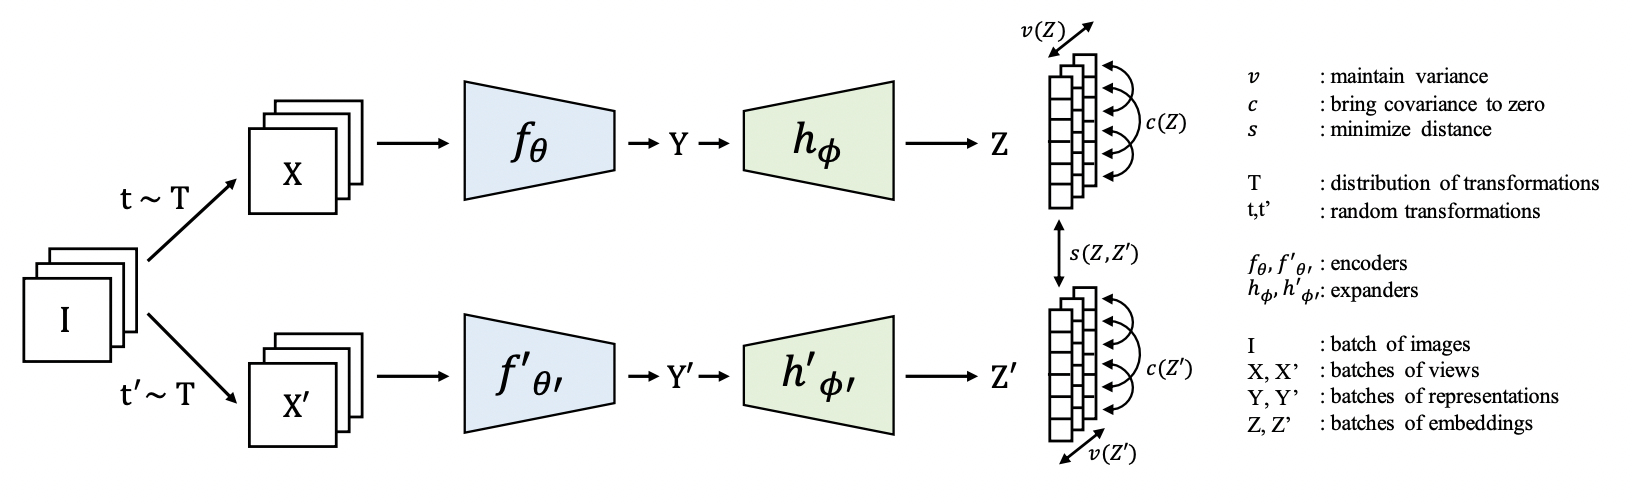


In [ ]:
class VICReg(nn.Module):
    def __init__(self, mlp="8192-8192-8192") -> None:
        super().__init__()
        self.num_features = int(mlp.split("-")[-1])
        self.encoder = torchvision_models.resnet50(zero_init_residual=True)
        self.embedding = self.encoder.fc.weight.shape[1]
        # This step is important as the implementation
        # of torchvision and the one used by the authors
        # are different
        self.encoder.fc = nn.Identity()
        self.expander = expander(self.embedding)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # Get Embeddings
        x = self.expander(self.encoder(x))
        y = self.expander(self.encoder(y))

        # Calculate the Representation (Invariance) Loss
        repr_loss = F.mse_loss(x, y)

        # Calculate var. and std. dev. of embeddings
        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)
        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)

        # Calculate the Variance Loss (Hinge Function)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        # Get Covariance Matrix
        cov_x = (x.T @ x) / (batch_size - 1)
        cov_y = (y.T @ y) / (batch_size - 1)

        # Calculate the Covariance Loss
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
            self.num_features
        ) + off_diagonal(cov_y).pow_(2).sum().div(self.num_features)

        # Weighted Avg. of Invariance, Variance and Covariance Loss
        loss = sim_coeff * repr_loss + std_coeff * std_loss + cov_coeff * cov_loss
        return loss


def expander(embedding: int) -> nn.Module:
    """
    Custom expander module to map the encoded representations
    into embeddings.

    * Representations -> y = f(x)
    * Embeddings -> z = h(y)
    """
    mlp_spec = f"{embedding}-8192-8192-8192"
    layers = []
    f = list(map(int, mlp_spec.split("-")))
    for i in range(len(f) - 2):
        layers.append(nn.Linear(f[i], f[i + 1]))
        layers.append(nn.BatchNorm1d(f[i + 1]))
        layers.append(nn.ReLU(True))
    layers.append(nn.Linear(f[-2], f[-1], bias=False))
    return nn.Sequential(*layers)


model = VICReg().cuda(gpu)

## LARS Optimizer

The training protocol for VICReg follows those of BYOL and Barlow Twins, i.e. the use of LARS which is adaptive algorithm meant for large batch training

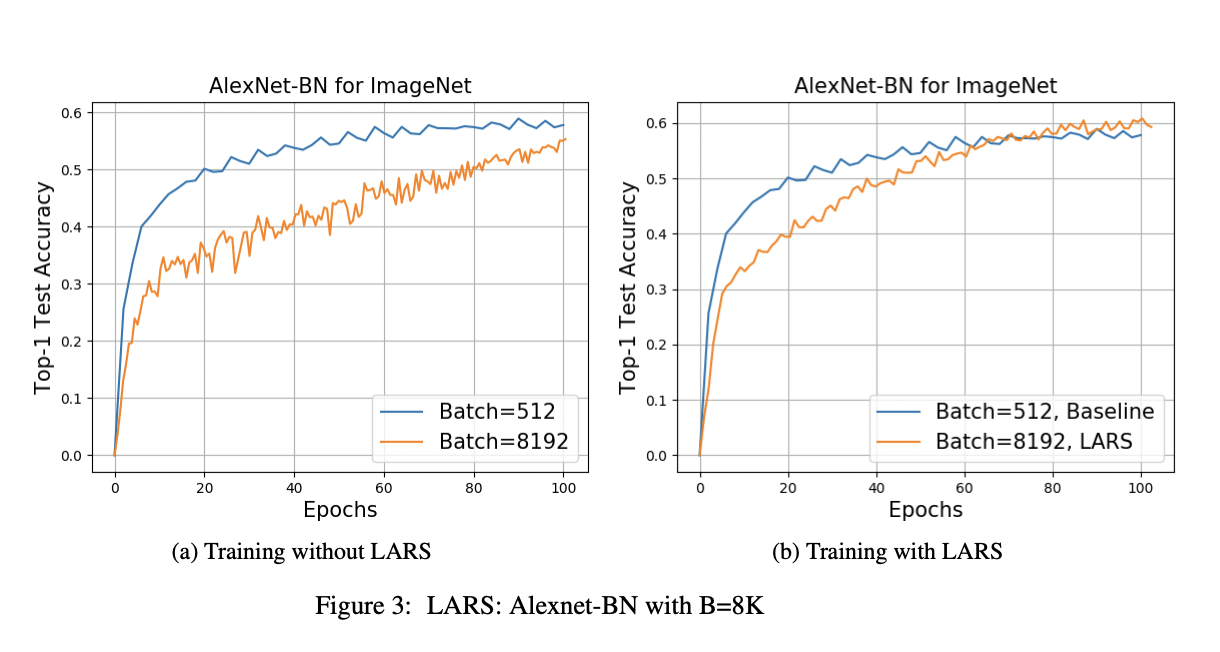

1. **Momentum update:**

$$\large
m_t = \beta_1m_{t-1} + (1 - \beta_1)(g_t + \lambda x_t)
$$


2. **Parameter update:**

$$\large
x_{t+1}^{(i)} = x_{t}^{(i)} - \eta_t \frac{\phi(|| x_{t}^{(i)} ||)}{|| m_{t}^{(i)} ||} m_{t}^{(i)}
$$

In [ ]:
optimizer = LARS(
  model.parameters(),
  lr=0,
  weight_decay=weight_decay,
  weight_decay_filter=exclude_bias_and_norm,
  lars_adaptation_filter=exclude_bias_and_norm,
)

## Training



In [ ]:
print("Starting VICReg training !")
scaler = torch.cuda.amp.GradScaler()
for epoch in range(epochs):
    for step, ((x, y), _) in track(enumerate(data_loader), total = len(data_loader)):
        x = x.cuda(gpu, non_blocking=True)
        y = y.cuda(gpu, non_blocking=True)

        # Change learning rate as per the custom cosine scheduler
        lr = adjust_learning_rate(epochs, optimizer, data_loader, step)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = model.forward(x, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Garbage Collection
        torch.cuda.empty_cache()
        _ = gc.collect()


    state = dict(
        epoch=epoch + 1,
        model=model.state_dict(),
        optimizer=optimizer.state_dict(),
    )
    torch.save(state, "./model.bin")